# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [25]:
import numpy as np
import pandas as pd
import cv2
np.random.seed(1)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import csv
import os
import tensorflow as tf


### Mount to drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change directory

In [4]:
pwd

'/content'

In [5]:
cd /content/drive/My Drive/Advanced Computer Vision/ACV_Lab

/content/drive/My Drive/Advanced Computer Vision/ACV_Lab


In [6]:
pwd

'/content/drive/My Drive/Advanced Computer Vision/ACV_Lab'

### Load the training data from train.csv file

In [7]:
training_data = pd.read_csv('train_labels.csv')

In [8]:
training_data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [9]:
training_data.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [14]:
IMAGE_SIZE =  128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width and height, x0, y0, x1, y1 in individual variables. <br>
1. Create a list variable known as 'paths' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be resized to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [15]:
with open('train_labels.csv', 'r') as csvfile:
  paths = []
  length = (sum(1 for line in csvfile))
  coords = np.zeros([length -1,4])
  spamreader = csv.reader(csvfile, delimiter =',')
  csvfile.seek(0)
  next(spamreader, None)
  for i, row in enumerate(spamreader):
    for j, r in enumerate(row):
      if((j!=0)&(j!=3)):
        row[j]=int(r)
    path, width, height, class_, xmin, ymin, xmax, ymax = row
    paths.append(path)
    coords[i,0] = (xmin * IMAGE_SIZE) / width
    coords[i,1] = (ymin * IMAGE_SIZE) / height
    coords[i,2] = (xmax * IMAGE_SIZE) / width
    coords[i,3] = (ymax * IMAGE_SIZE) / height


In [16]:
coords[0]

array([46.94980695, 39.58762887, 82.53281853, 77.8556701 ])

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [21]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
for i, f in enumerate(paths):
  img = Image.open('images_racoon-1/images/' + f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = tf.keras.applications.mobilenet.preprocess_input(np.array(img, dtype = np.float32))



In [22]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3.
### Freeze all the layers and Add convolution layers and reshape layers at the end to ensure the output has 4 coordinates.

In [34]:
from tensorflow.keras.applications.mobilenet import MobileNet 
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras import Model

In [36]:
model =  MobileNet(input_shape =(IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, alpha =1.0)
for layer in model.layers:
  layer.trainable = False

x = model.output
x = Conv2D(4, kernel_size=4, name='coords')(x)
x = Reshape((4,))(x)
model = Model(inputs = model.input, outputs = x)

## Plot the model and view the whole skeleton using plot_model.

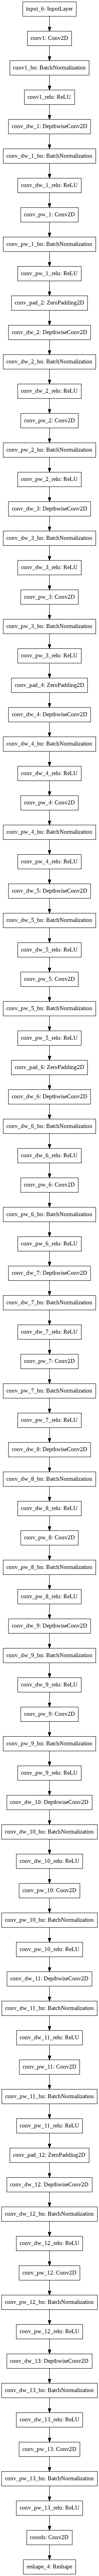

In [37]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes = False, show_dtype = False, 
                          show_layer_names=True, rankdir='TB', dpi =96)

### Define a custom loss function IoU which calculates Intersection Over Union

In [44]:
from tensorflow.keras.backend import epsilon
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [45]:
model.compile(optimizer = 'Adam', loss = 'mse', metrics =[IoU])

In [46]:
model.fit(batch_images, coords, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
6/6 [==============================] - 4s 291ms/step - loss: 4120.0112 - IoU: 0.0853
Epoch 2/30
6/6 [==============================] - 2s 292ms/step - loss: 747.1700 - IoU: 0.4234
Epoch 3/30
6/6 [==============================] - 2s 290ms/step - loss: 487.8577 - IoU: 0.5687
Epoch 4/30
6/6 [==============================] - 2s 292ms/step - loss: 626.6933 - IoU: 0.5354
Epoch 5/30
6/6 [==============================] - 2s 297ms/step - loss: 352.9392 - IoU: 0.6136
Epoch 6/30
6/6 [==============================] - 2s 286ms/step - loss: 196.0627 - IoU: 0.6574
Epoch 7/30
6/6 [==============================] - 2s 289ms/step - loss: 201.0053 - IoU: 0.6583
Epoch 8/30
6/6 [==============================] - 2s 295ms/step - loss: 163.0050 - IoU: 0.7028
Epoch 9/30
6/6 [==============================] - 2s 293ms/step - loss: 127.8309 - IoU: 0.7377
Epoch 10/30
6/6 [==============================] - 2s 290ms/step - loss: 114.9018 - IoU: 0.7601
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

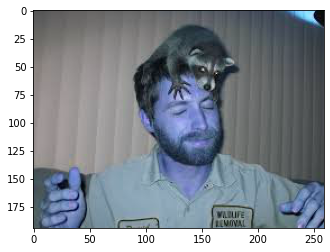

In [60]:
filename = 'images_racoon-1/images/raccoon-19.jpg'
unscaled = cv2.imread(filename)
plt.imshow(unscaled)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [61]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = tf.keras.applications.mobilenet.preprocess_input(np.array(image, dtype = np.float32))


### Predict the coordinates of the bounding box for the given test image

In [62]:
region = model.predict(x= np.array([feat_scaled]))[0]


In [63]:
region

array([35.107967,  4.379961, 82.1598  , 66.93056 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

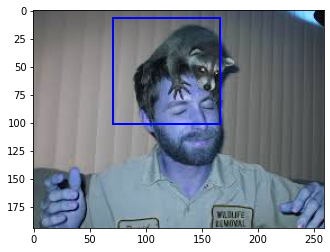

In [64]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# VGG16 Implementation

# VGG 16 Implementation
### Define a variable Image_size which takes accurate input according to the VGG16 model. 

In [69]:
IMAGE_SIZE = 224

### With the help of csvr.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 224 * 224 

In [70]:
with open('train_labels.csv', 'r') as csvfile:
  paths = []
  length = (sum(1 for line in csvfile))
  coords = np.zeros([length -1,4])
  spamreader = csv.reader(csvfile, delimiter =',')
  csvfile.seek(0)
  next(spamreader, None)
  for i, row in enumerate(spamreader):
    for j, r in enumerate(row):
      if((j!=0)&(j!=3)):
        row[j]=int(r)
    path, width, height, class_, xmin, ymin, xmax, ymax = row
    paths.append(path)
    coords[i,0] = (xmin * IMAGE_SIZE) / width
    coords[i,1] = (ymin * IMAGE_SIZE) / height
    coords[i,2] = (xmax * IMAGE_SIZE) / width
    coords[i,3] = (ymax * IMAGE_SIZE) / height


In [71]:
coords.shape

(173, 4)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the VGG16 accepts 3 channels as inputs   

In [74]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
for i, f in enumerate(paths):
  img = Image.open('images_racoon-1/images/' + f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = tf.keras.applications.vgg16.preprocess_input(np.array(img, dtype = np.float32))

In [75]:
batch_images[0].shape

(224, 224, 3)

### Define a vgg16 model and plot the model using plot_model function.
Hint:- Use RepeatVector,Conv1D,GlobalAveragePooling2D(optional to learner)

In [76]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, RepeatVector, Conv1D, Flatten, Dense

In [79]:
model_vgg = VGG16(weights = 'imagenet', include_top= False, input_shape = (IMAGE_SIZE, IMAGE_SIZE,3))
for layer in model_vgg.layers:
  layer.trainable = False

x2 = model_vgg.output
x2 = GlobalAveragePooling2D()(x2)
x2 = RepeatVector(8)(x2)
x2 = Conv1D(4, kernel_size=8, name  = 'coords')(x2)
x2 = Flatten()(x2)

Model_vgg = Model(inputs = model_vgg.input, outputs = x2)

### Plot the Vgg16 model using plot_model function.

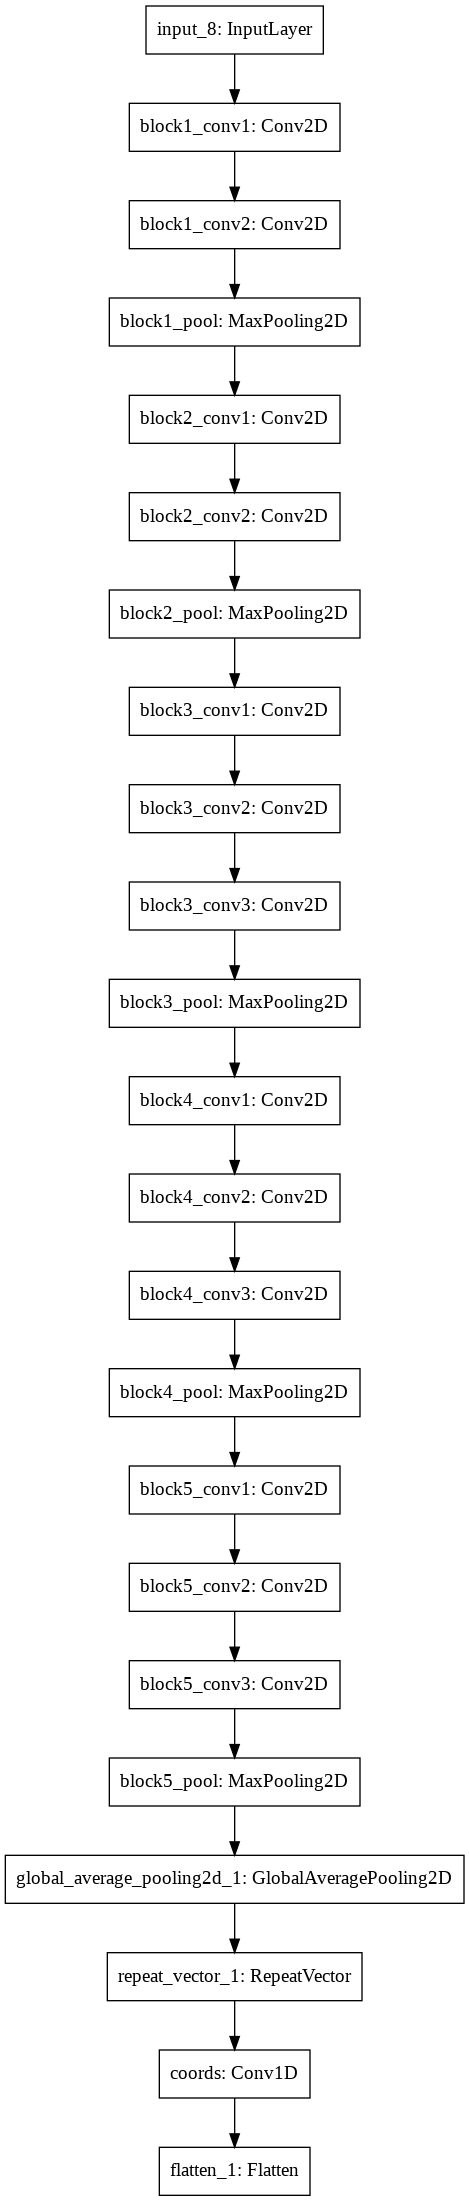

In [81]:
tf.keras.utils.plot_model(Model_vgg, to_file='model_vgg.png', show_shapes = False, show_dtype = False, 
                          show_layer_names=True, rankdir='TB', dpi =96)

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [82]:
Model_vgg.compile(optimizer='Adam', loss = 'mse', metrics = [IoU])

In [83]:
Model_vgg.fit(batch_images, coords, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
6/6 [==============================] - 57s 9s/step - loss: 14247.0039 - IoU: 0.0538
Epoch 2/30
6/6 [==============================] - 56s 9s/step - loss: 5490.2798 - IoU: 0.2259
Epoch 3/30
6/6 [==============================] - 56s 9s/step - loss: 2095.6467 - IoU: 0.4225
Epoch 4/30
6/6 [==============================] - 56s 9s/step - loss: 1954.8363 - IoU: 0.4747
Epoch 5/30
6/6 [==============================] - 55s 9s/step - loss: 2163.7288 - IoU: 0.4738
Epoch 6/30
6/6 [==============================] - 56s 9s/step - loss: 1893.8708 - IoU: 0.4839
Epoch 7/30
6/6 [==============================] - 55s 9s/step - loss: 1537.1567 - IoU: 0.5048
Epoch 8/30
6/6 [==============================] - 55s 9s/step - loss: 1412.5189 - IoU: 0.5121
Epoch 9/30
6/6 [==============================] - 55s 9s/step - loss: 1388.4720 - IoU: 0.5054
Epoch 10/30
6/6 [==============================] - 55s 9s/step - loss: 1323.7760 - IoU: 0.5281
Epoch 11/30
6/6 [==============================] - 55s 9s/

### Pick a test image from the given data

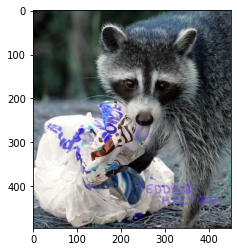

In [92]:
filename = 'images_racoon-1/images/raccoon-10.jpg'
unscaled = cv2.imread(filename)
plt.imshow(unscaled)

### Resize the image to 224 * 224 and preprocess the image for the VGG16

In [89]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = tf.keras.applications.vgg16.preprocess_input(np.array(image, dtype = np.float32))

### Predict the coordinates of the bounding box for the given test image

In [90]:
region = Model_vgg.predict(x= np.array([feat_scaled]))[0]

In [94]:
region

array([ 58.35479 ,   9.843051, 248.38266 , 263.87155 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

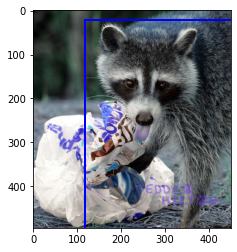

In [93]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()